In [174]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
path = 'C:\Users\Charlie2\Documents\pubg stat'
filename_sample = path + '\\sample_submission_V2.csv'
filename_test = path + '\\test_V2.csv'
filename_train = path + '\\train_V2.csv'
#test_data = pd.read_csv(filename_test)

In [175]:
# REMEMBER to add the engineered features to the test set as well

In [176]:
filename_train

'C:\\Users\\Charlie2\\Documents\\pubg stat\\train_V2.csv'

In [177]:
train_data= pd.read_csv(filename_train)

MemoryError: 

In [ ]:
train_data.describe()

In [178]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 967044 to 4354560
Data columns (total 37 columns):
assists                  5000 non-null int64
boosts                   5000 non-null int64
damageDealt              5000 non-null float64
DBNOs                    5000 non-null int64
headshotKills            5000 non-null int64
heals                    5000 non-null int64
killPlace                5000 non-null int64
killPoints               5000 non-null int64
kills                    5000 non-null int64
killStreaks              5000 non-null int64
longestKill              5000 non-null float64
matchDuration            5000 non-null int64
maxPlace                 5000 non-null int64
numGroups                5000 non-null int64
rankPoints               5000 non-null int64
revives                  5000 non-null int64
rideDistance             5000 non-null float64
roadKills                5000 non-null int64
swimDistance             5000 non-null float64
teamKills             

In [ ]:
# Let's start validating data by making sure every player placed at the end of the match
# Let's check for a row with a NaN value in that column.
train_data[train_data['winPlacePerc'].isnull()]

In [ ]:
# Dropping that illegal match with only one player from the dataset.
train_data.dropna(subset=['winPlacePerc'], inplace=True)

In [ ]:
# Confirming the player is gone.
train_data.iloc[2744604:2744604+1]

# Normalizing features

In [ ]:
# A game in PUBG can have up to 100 players fighting each other, but most of the times a game isn't "full" at 100. 
# There is no variable that gives us the number of players who joined the match, but it would be good to create one
# to help normalize the data.
train_data['playersJoined'] = train_data.groupby('matchId')['matchId'].transform('count')

In [ ]:
data = train_data.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

In [ ]:
# We need to figure out how to standardize the data, each match has a different number of players,
# so we should normalize other features based on the amount of players.
# Based on the "playersJoined" feature we can create (or change) a lot of others to normalize their values. 
# For example we can, create the "killsNorm" and "damageDealtNorm" features. 
# When there are 100 players in the game it might be easier to find and kill someone, than when there are 90 players. 
# So we can normalize the kills in a way that a kill in 100 players will score 1 (as it is) and in 90 players it will 
# score (100-90)/100 + 1 = 1.1. This is just an assumption and different scales could be used.

train_data['killsNormalized'] = train_data['kills']*((100-train_data['playersJoined'])/100 + 1)
train_data['damageDealtNormalized'] = train_data['damageDealt']*((100-train_data['playersJoined'])/100 + 1)
train_data[['playersJoined', 'kills', 'killsNormalized', 'damageDealt', 'damageDealtNormalized']][5:8]

In [197]:
train_data.drop(['kills'], inplace=True, axis=1)
train_data.drop(['damageDealt'], inplace=True, axis=1)

train_dummy = train_data
#train_dummy.groupby(['matchId']).mean()
playerCount = train_dummy.groupby(['matchId']).count()
playerCount = playerCount["Id"].values
n, bins, patches = plt.hist(playerCount, bins=100)
#bins

In [ ]:
print(("Mean player count: %d") % np.mean(playerCount))
print(("Median player count: %d") % np.ma.median(playerCount))
print(("Standard deviation of player count: %d") % np.std(playerCount))

scaledCount = [0]*len(playerCount)
i = 0
for x in playerCount:
    scaledCount[i] = ((x-np.mean(playerCount))/np.std(playerCount))
    i = i + 1
plt.hist(scaledCount, bins=100)
#Normal standardization probably isn't effective

# Categorical Variables

In [ ]:
# Creating a column that determines if a player placed in the top 10 percent
train_data['winBinary'] = train_data['winPlacePerc']
def makeDummieVar(winPercent):
    if (winPercent >= 0.9):
        winPercent = 1
    else:
        winPercent = 0
    return winPercent

train_data['winBinary'] = train_data['winBinary'].apply(makeDummieVar)
train_data.head(5)

In [ ]:
np.unique(train_data['matchType'])

In [ ]:
# To make things less complicated, we should only look at standard matches.
# According to the given information, the standard modes are:
# “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”.
# (The -fpp appeneded means the game forced all players to use a "first-person perspective",
# rather, than giving them the option between first-person and third-person to switch between.)
train_data = train_data[(train_data.matchType == 'solo') | (train_data.matchType == 'duo') |
                        (train_data.matchType == 'squad') | (train_data.matchType == 'solo-fpp') |
                        (train_data.matchType == 'duo-fpp') | (train_data.matchType == 'squad-fpp')]
np.unique(train_data['matchType'])

In [ ]:
sample = 5000
train_data = train_data.sample(sample)

In [ ]:
# Drop Id column, because it probably won't be useful for our Machine Learning algorithm,
# because the test set contains different Id's
train_data.drop(['Id'], inplace=True, axis=1)

In [ ]:
# Need to "One hot encode" the matchType feature to 
# perform “binarization” of the category and include it as a feature to train the model.
# This converts the categorical matchType variable into a form that could be provided to 
# ML algorithms to do a better job in prediction.

train_data = pd.get_dummies(train_data, columns=['matchType'])

In [ ]:
# Taking a look at the encoding.
matchType_encoding = train_data.filter(regex='matchType')
matchType_encoding.head()

In [ ]:
# matchId's and groupId's are the other categorical variables. There are a ton of different ones so
# one hot encoding them makes no sense, but there could still be corrleations between them, as one
# match will have different charcteristics than the next, and the same goes for groups, so we should
# categorize them with Pandas.

In [ ]:
train_data['groupId'] = train_data['groupId'].astype('category')
train_data['matchId'] = train_data['matchId'].astype('category')

# Get category coding for groupId and matchID
train_data['groupId_cat'] = train_data['groupId'].cat.codes
train_data['matchId_cat'] = train_data['matchId'].cat.codes

# Get rid of old columns
train_data.drop(['groupId', 'matchId'], inplace=True, axis=1)

train_data[['groupId_cat', 'matchId_cat']].head()

# Feature Selection

In [ ]:
# from sklearn.linear_model import LogisticRegression
# logReg = LogisticRegression()

In [ ]:
wpp = train_data['winPlacePerc']
train_data.drop(labels=['winPlacePerc'], axis=1,inplace = True)
train_data.insert(36, 'winPlacePerc', wpp)
wb = train_data['winBinary']

In [198]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 967044 to 4354560
Data columns (total 35 columns):
assists                  5000 non-null int64
boosts                   5000 non-null int64
DBNOs                    5000 non-null int64
headshotKills            5000 non-null int64
heals                    5000 non-null int64
killPlace                5000 non-null int64
killPoints               5000 non-null int64
killStreaks              5000 non-null int64
longestKill              5000 non-null float64
matchDuration            5000 non-null int64
maxPlace                 5000 non-null int64
numGroups                5000 non-null int64
rankPoints               5000 non-null int64
revives                  5000 non-null int64
rideDistance             5000 non-null float64
roadKills                5000 non-null int64
swimDistance             5000 non-null float64
teamKills                5000 non-null int64
vehicleDestroys          5000 non-null int64
walkDistance            

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

# Take sample for debugging and exploration
#sample = 50000
#df_sample = train_data.sample(sample)
df_sample = train_data

In [189]:
df_sample = train_data
lr_sample = train_data

In [190]:
# Split sample into training data and target variable
X = df_sample.drop(['winPlacePerc', 'winBinary'], inplace=False, axis=1) #all columns except target.
y = df_sample['winPlacePerc'] # Only target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22,shuffle=True)
print('X_train.shape %s, X_test.shape %s\ny_train.shape %s, y_test.shape %s'%(X_train.shape,X_test.shape,y_train.shape,y_test.shape))
#Xlr = lr_sample.drop(['winPlacePerc', 'winBinary'], inplace=False, axis=1)
#ylr = df_sample['winBinary']
#Xlr_train, Xlr_test, ylr_train, ylr_test = train_test_split(Xlr, ylr, test_size=0.3, random_state=22,shuffle=True)

X_train.shape (3500, 35), X_test.shape (1500, 35)
y_train.shape (3500L,), y_test.shape (1500L,)


In [205]:
model_rfe = LogisticRegression()
rfe = RFE(model_rfe, 1)
X_train_int = X_train.astype('int')
y_train_int = (y_train * 100).astype('int')
fit = rfe.fit(X_train_int,y_train_int)
#print(("Num Features: %d") % fit.n_features_)
#print(("Selected Features: %s") % fit.support_)

In [206]:
len(X_train.columns)

35

In [207]:
len(fit.ranking_)

35

In [210]:
featureNames = [0] * len(X_train.columns)
for f in range(len(X_train.columns)):
    featureNames[f] = list(X_train)[f]

In [224]:
rfeRanks.sort_values('ranking')
rfeRanks['feature']

32      matchType_squad-fpp
31          matchType_squad
1                    boosts
28        matchType_duo-fpp
27            matchType_duo
30       matchType_solo-fpp
29           matchType_solo
15                  revives
19                teamKills
4             headshotKills
0                   assists
22          weaponsAcquired
17                roadKills
9               killStreaks
8                     kills
20          vehicleDestroys
3                     DBNOs
5                     heals
25          killsNormalized
18             swimDistance
12                 maxPlace
13                numGroups
24            playersJoined
6                 killPlace
2               damageDealt
26    damageDealtNormalized
10              longestKill
16             rideDistance
23                winPoints
14               rankPoints
7                killPoints
21             walkDistance
11            matchDuration
33              groupId_cat
34              matchId_cat
Name: feature, dtype

In [219]:
print("Feature Ranking, From Recursive Feature Elimination:")
rfeRanks = pd.DataFrame({'ranking':fit.ranking_,'feature':featureNames})
rfeRanks.sort_values('ranking')
for f in range(X.shape[1]):
    print("%d. %s" % (f + 1, rfeRanks['feature'][f]))

Feature Ranking, From Recursive Feature Elimination:
1. assists
2. boosts
3. damageDealt
4. DBNOs
5. headshotKills
6. heals
7. killPlace
8. killPoints
9. kills
10. killStreaks
11. longestKill
12. matchDuration
13. maxPlace
14. numGroups
15. rankPoints
16. revives
17. rideDistance
18. roadKills
19. swimDistance
20. teamKills
21. vehicleDestroys
22. walkDistance
23. weaponsAcquired
24. winPoints
25. playersJoined
26. killsNormalized
27. damageDealtNormalized
28. matchType_duo
29. matchType_duo-fpp
30. matchType_solo
31. matchType_solo-fpp
32. matchType_squad
33. matchType_squad-fpp
34. groupId_cat
35. matchId_cat


In [220]:
for f in range(len(fit.support_)):
    if fit.support_[f] == True:
        print featureNames[f]

matchType_squad-fpp


In [ ]:
print(__doc__)

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

X_int = X.astype('int')
y_int = (y * 100).astype('int')

# Create the RFE object and compute a cross-validated score.
#svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(model_rfe, step=1, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv.fit(X_int,y_int)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# USE THE TOP FEATURES FROM RFECV IN THE RFR

In [ ]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# mae is the criteron for the dataset
rfr = RandomForestRegressor(max_depth=500,criterion='mae',
                            max_features=None,n_estimators=75,bootstrap=True,
                            min_samples_leaf=1,n_jobs=1,min_samples_split=2)
rfr.fit(X_train,y_train)

In [ ]:
#print_score(rfr)
res = ['mae train: ', mean_absolute_error(rfr.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(rfr.predict(X_test), y_test)]
if hasattr(rfr, 'oob_score_'): res.append(rfr.oob_score_)
print(res)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
y_pred_rfr = rfr.predict(X_test)
# r2_score score: 1 is perfect prediction
rfr_score=r2_score(y_pred=y_pred_rfr,y_true=y_test)
print("Variance score (r2_score): %f"%rfr_score)
print('Model accuracy:%.2f '%(rfr_score*100))

In [180]:
RFpredictions = pd.DataFrame(data=y_pred_rfr)
frames = [RFpredictions, y_test.reset_index().iloc[:,1]]
modelTest = pd.concat(frames, axis=1)
modelTest.columns = ["Random Forest Predicted", "Actual"]
modelTest.head(10)

,Random Forest Predicted,Actual
0,0.079565,0.0000
1,0.536459,0.6875
2,0.821248,0.9630
3,0.604904,0.6154
4,0.762304,0.8000
5,0.280073,0.2917
6,0.181584,0.1364
7,0.822052,0.7200
8,0.278768,0.2593
9,0.763428,0.6897


In [ ]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking, from Random Forest Regressor:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, featureNames[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
#idk if scaling the data is right, so ill take it out

In [ ]:
for f in range(len(fit.ranking_)):
    if fit.ranking_[f] == 1:
        print featureNames[f]

In [ ]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression()

In [ ]:
logReg.fit(Xlr_train, ylr_train)

In [ ]:
yp = logReg.predict(Xlr_test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(ylr_test, yp)
confusion_m
#1319+75 = 1394 correct predictions
#33+73 = 106 incorrect predictions



In [ ]:
from __future__ import division

In [ ]:
accuracy = (confusion_m[0,0]+confusion_m[1,1])/sum(map(sum, confusion_m))
print(accuracy)
#print(("Percent Accuracy: %d") % accuracy)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
lra = roc_auc_score(ylr_test, yp)
fpr, tpr, thresholds = roc_curve(ylr_test, logReg.predict_proba(Xlr_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lra)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
#Logistic Regression Model significantly better at predicting a top 10% finish than random guessing

In [ ]:
lr_score = r2_score(ylr_test, yp)
print("Variance score (r2_score): %f"%lr_score)

In [ ]:
LRpredictions = pd.DataFrame(data=yp)
frames = [LRpredictions, ylr_test.reset_index().iloc[:,1]]
modelTest = pd.concat(frames, axis=1)
modelTest.columns = ["Logistic Regression Predicted", "Actual"]
modelTest.head(15)

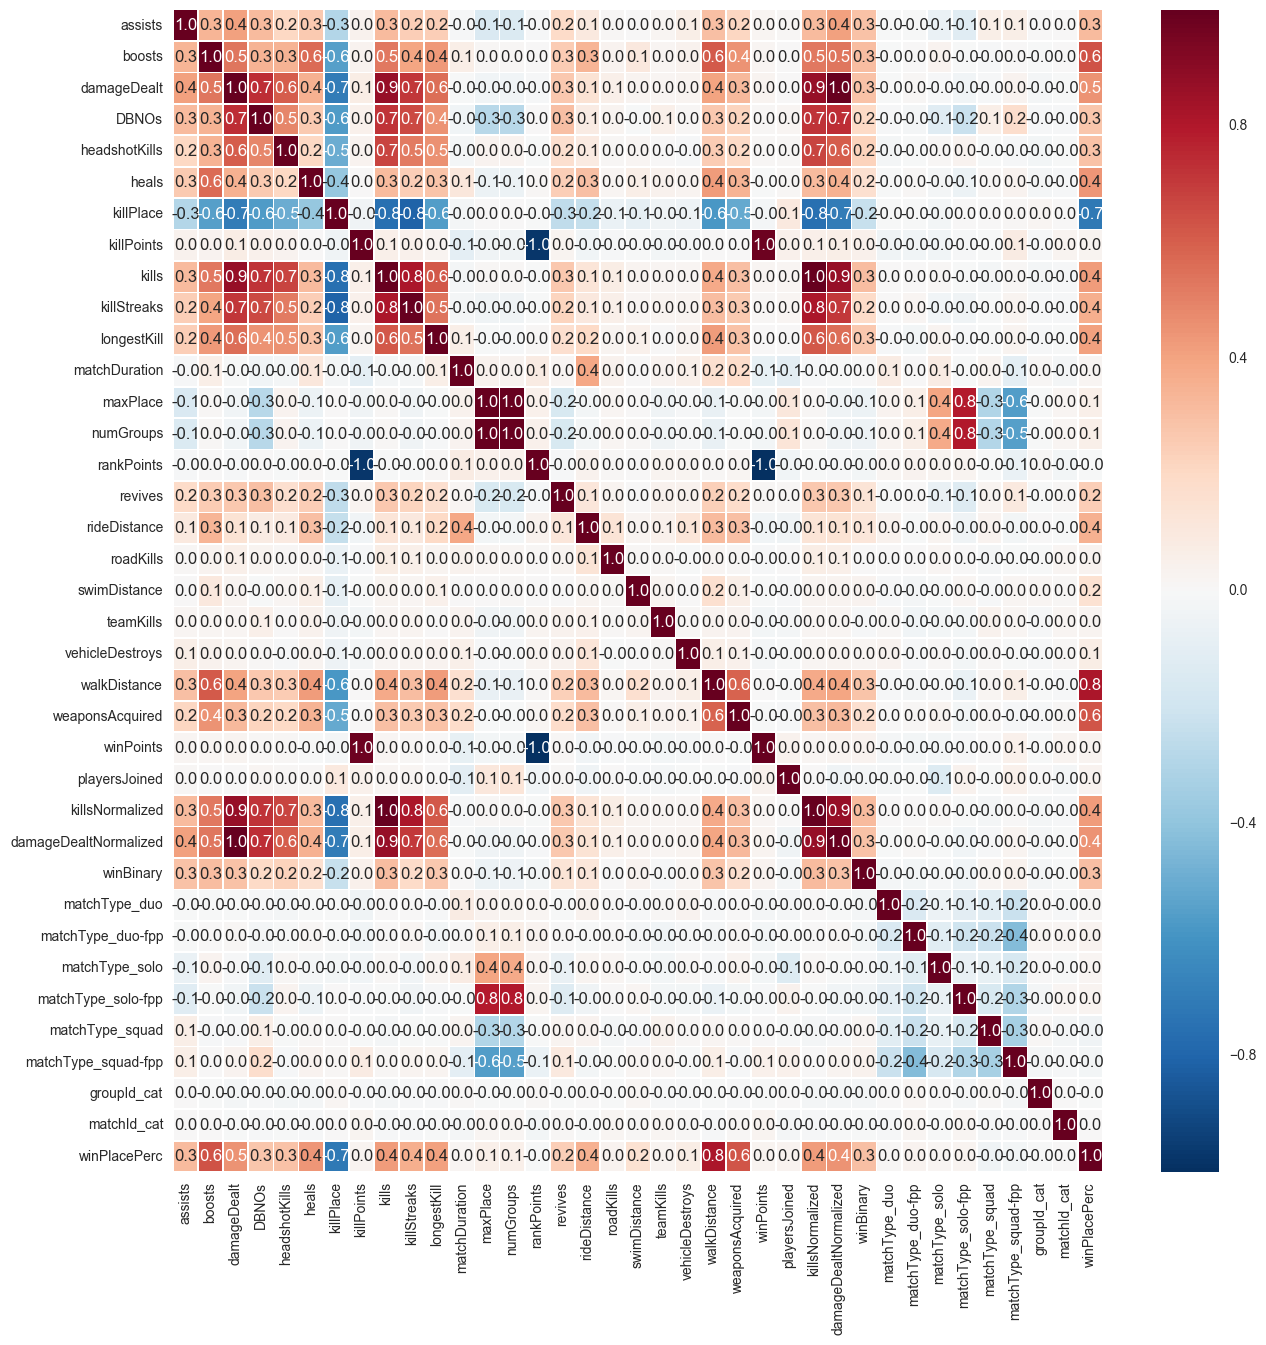

In [185]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train_data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [ ]:
logReg.fit(Xlr_train, ylr_train)

In [ ]:
yp = logReg.predict(Xlr_test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(ylr_test, yp)
confusion_m
#1319+75 = 1394 correct predictions
#33+73 = 106 incorrect predictions

In [ ]:
from __future__ import division

In [ ]:
accuracy = (confusion_m[0,0]+confusion_m[1,1])/sum(map(sum, confusion_m))
print(round(accuracy, 2))
#print(("Percent Accuracy: %d") % accuracy)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
lra = roc_auc_score(ylr_test, yp)
fpr, tpr, thresholds = roc_curve(ylr_test, logReg.predict_proba(Xlr_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lra)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
#Logistic Regression Model significantly better at predicting a top 10% finish than random guessing

In [ ]:
lr_score = r2_score(ylr_test, yp)
print("Variance score (r2_score): %f"%lr_score)

In [ ]:
LRpredictions = pd.DataFrame(data=yp)
frames = [LRpredictions, ylr_test.reset_index().iloc[:,1]]
modelTest = pd.concat(frames, axis=1)
modelTest.columns = ["Logistic Regression Predicted", "Actual"]
modelTest.head(15)

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.Logit(ylr_train, Xlr_train) 
result = model.fit()

In [ ]:
result.summary()

In [ ]:
result.aic